In [30]:
import numpy as np

one_hot_v = np.array([[1, 0, 0, 0, 0, 0, 0]])
W = np.random.randn(7, 3)
h = np.dot(one_hot_v, W)

print(h)

[[-0.33749859  0.86755397  0.232335  ]]


In [31]:
from util import softmax, CEE
from layer import Softmax_with_Loss, MatMul

layer = MatMul(W)

h = layer.forward(one_hot_v)

print(h)

[[-0.33749859  0.86755397  0.232335  ]]


In [32]:
one_hot_v1 = np.array([[1, 0, 0, 0, 0, 0, 0]])
one_hot_v2 = np.array([[0, 0, 1, 0, 0, 0, 0]])

h = np.concatenate((one_hot_v1, one_hot_v2), axis=0)
np.sum(h, axis=0)

array([1, 0, 1, 0, 0, 0, 0])

In [33]:
one_hot_v1 = np.array([[1, 0, 0, 0, 0, 0, 0]])
one_hot_v2 = np.array([[0, 0, 1, 0, 0, 0, 0]])

input_size = 7
hidden_size = 3
output_size = 7

W_in = np.random.randn(input_size, hidden_size)
W_out = np.random.randn(hidden_size, output_size)

encoding_layer = MatMul(W_in)
decoding_layer = MatMul(W_out)

context = np.concatenate((one_hot_v1, one_hot_v2), axis=0)
context_len = len(context)
hidden_states = encoding_layer.forward(context)
hidden_state = np.sum(hidden_states, axis=0)/context_len

logit = decoding_layer.forward(hidden_state)
logit

array([ 1.15063305, -0.37056802, -0.75832033, -0.46909562, -1.25209343,
       -0.3369435 ,  0.28156394])

In [34]:
import numpy as np
from util import preprocess, create_co_matrix

def create_contexts_target(corpus, window_size=1):
    corpus, word_to_id, id_to_word = preprocess(corpus)
    corpus_len = len(corpus)
    
    targets = corpus[window_size: corpus_len - window_size]
    contexts = None
    
    for index in range(window_size, corpus_len - window_size):
        context = np.concatenate((corpus[index - window_size:index], corpus[index + 1:index + window_size+1])).reshape(1, 2*window_size)
        if contexts is None:
            contexts = context
        else:
            contexts = np.concatenate((contexts, context), axis=0)
    
    return contexts, targets

In [35]:
corpus = "You say goodbye and I say hello."

contexts, targets = create_contexts_target(corpus, window_size=1)
corpus, word_to_id, id_to_word = preprocess(corpus)


print(f"corpus : {corpus}")
print(f"contexts :\n{contexts}\ntargets : {targets}")

corpus : [0 1 2 3 4 1 5 6]
contexts :
[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
targets : [1 2 3 4 1 5]


In [36]:
def convert_one_hot(word_id_list, vocab_size):
    one_hot_vectors = []
    
    if word_id_list.ndim == 1:
        for id in word_id_list:
            one_hot_vector = [1 if i == id else 0 for i in range(vocab_size)]
            one_hot_vectors.append(one_hot_vector)
    else:
        for word_ids in word_id_list:
            one_hot_vector_list = []
            for id in word_ids:
                one_hot_vector = [1 if i == id else 0 for i in range(vocab_size)]
                one_hot_vector_list.append(one_hot_vector)
                
            one_hot_vectors.append(one_hot_vector_list)
    return np.array(one_hot_vectors)

In [37]:
targets = convert_one_hot(targets, len(word_to_id))
contexts = convert_one_hot(contexts, len(word_to_id))

In [38]:
print(targets)
print(contexts)

[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]]


In [ ]:
from layer import MatMul, Softmax_with_Loss

class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        self.context_size = None
        self.batch_size = None
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.params = []
        self.grads = []
        
        input_size = vocab_size
        output_size = vocab_size
        
        W_in = 0.01 * np.random.randn(input_size, hidden_size).astype('f')
        W_out = 0.01 * np.random.randn(hidden_size, output_size).astype('f')
        
        self.word_vecs = W_in
        
        self.layers = []
        self.layers.append(MatMul(W_in))
        self.layers.append(MatMul(W_out))
        
        self.last_layer = Softmax_with_Loss()

        for layer in self.layers:
            for param, grad in zip(layer.params, layer.grads):
                self.params.append(param)
                self.grads.append(grad)
        
    def predict(self, contexts):
        self.batch_size, self.context_size, _ = contexts.shape
        
        contexts = contexts.reshape(self.batch_size*self.context_size, self.vocab_size) # (B*C, V)
        hidden_states = self.layers[0].forward(contexts)                                # (B*C, H)
        hidden_states = hidden_states.reshape(self.batch_size, self.context_size, -1)   # (B, C, H)
        hidden_states = np.sum(hidden_states, axis=1) / self.context_size               # (B, H)
        logits = self.layers[1].forward(hidden_states)                                  # (B, V)
        
        return logits
    
    def loss(self, contexts, targets):
        logits = self.predict(contexts)
        loss = self.last_layer.forward(logits, targets)
        
        return loss
    
    def backward(self, dout=1):
        dout = self.last_layer.backward(dout)                           # (B, V)

        dout = self.layers[1].backward(dout)                            # (B, H)

        dout = dout / self.context_size                                 # (B, H)
        dout = dout[:, None, :]                                         # (B, 1, H)
        dout = np.repeat(dout, self.context_size, axis=1)               # (B, C, H)

        dout = dout.reshape(self.batch_size * self.context_size, -1)    # (B*C, H)
        dout = self.layers[0].backward(dout)                            # (B*C, V)

        return dout.reshape(self.batch_size, self.context_size, self.vocab_size)    
    

In [41]:
from optimizer import Adam
from trainer import Trainer

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

# 전처리
text = "You say goodbye and I say hello"
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts_ids, targets_ids = create_contexts_target(text, window_size=1)

target = convert_one_hot(targets_ids, vocab_size)
contexts = convert_one_hot(contexts_ids, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam(lr=0.001)
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size, eval_interval=1)

| epoch 1 | iteration 1/2 | loss : 1.7917 |
| epoch 1 | iteration 2/2 | loss : 1.7917 |
| epoch 2 | iteration 1/2 | loss : 1.7916 |
| epoch 2 | iteration 2/2 | loss : 1.7916 |
| epoch 3 | iteration 1/2 | loss : 1.7915 |
| epoch 3 | iteration 2/2 | loss : 1.7916 |
| epoch 4 | iteration 1/2 | loss : 1.7915 |
| epoch 4 | iteration 2/2 | loss : 1.7913 |
| epoch 5 | iteration 1/2 | loss : 1.7913 |
| epoch 5 | iteration 2/2 | loss : 1.7912 |
| epoch 6 | iteration 1/2 | loss : 1.7912 |
| epoch 6 | iteration 2/2 | loss : 1.7911 |
| epoch 7 | iteration 1/2 | loss : 1.7911 |
| epoch 7 | iteration 2/2 | loss : 1.7908 |
| epoch 8 | iteration 1/2 | loss : 1.7909 |
| epoch 8 | iteration 2/2 | loss : 1.7906 |
| epoch 9 | iteration 1/2 | loss : 1.7905 |
| epoch 9 | iteration 2/2 | loss : 1.7907 |
| epoch 10 | iteration 1/2 | loss : 1.7904 |
| epoch 10 | iteration 2/2 | loss : 1.7901 |
| epoch 11 | iteration 1/2 | loss : 1.7903 |
| epoch 11 | iteration 2/2 | loss : 1.7895 |
| epoch 12 | iteration 1/2 |

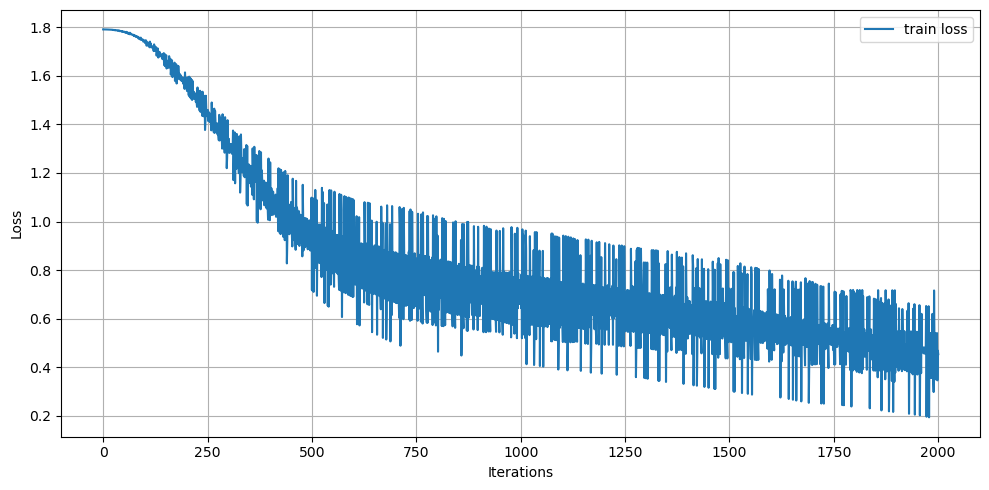

In [42]:
trainer.plot()

In [46]:
word_vecs = model.word_vecs
word_to_vec = {}
for word_id, word, in id_to_word.items():
    word_to_vec[word] = word_vecs[word_id]
    print(word, word_vecs[word_id])

you [ 0.01495337 -0.00565978  0.00926801 -0.00238397  0.0078771 ]
say [0.00758252 0.00489926 0.01536164 0.01137499 0.01352047]
goodbye [-0.00208442  0.00589753 -0.00589077  0.003712    0.01023927]
and [ 0.01505817 -0.0061972  -0.01032627  0.00358621 -0.00133909]
i [-0.00478475  0.0001463   0.00269014 -0.00688716  0.00794619]
hello [-0.00179926 -0.00272473 -0.00057306 -0.00993888  0.01048789]


In [47]:
word_to_vec

{'you': array([ 0.01495337, -0.00565978,  0.00926801, -0.00238397,  0.0078771 ],
       dtype=float32),
 'say': array([0.00758252, 0.00489926, 0.01536164, 0.01137499, 0.01352047],
       dtype=float32),
 'goodbye': array([-0.00208442,  0.00589753, -0.00589077,  0.003712  ,  0.01023927],
       dtype=float32),
 'and': array([ 0.01505817, -0.0061972 , -0.01032627,  0.00358621, -0.00133909],
       dtype=float32),
 'i': array([-0.00478475,  0.0001463 ,  0.00269014, -0.00688716,  0.00794619],
       dtype=float32),
 'hello': array([-0.00179926, -0.00272473, -0.00057306, -0.00993888,  0.01048789],
       dtype=float32)}

In [50]:
def norm(x):
    eps = 1e-8
    if x.ndim == 1:
        return np.sqrt(np.sum(x**2) + eps)
    else:
        return np.sqrt(np.sum(x**2, axis=1) + eps)

def most_similar(query, word_to_id, id_to_word, word_matrix, top):
    eps = 1e-8
    query_word_id = word_to_id[query]
    
    query_vector = word_matrix[query_word_id]
    similarities = np.dot(word_matrix, query_vector) / (norm(word_matrix) * norm(query_vector))
    top_sim_word_ids = np.argsort(similarities)[::-1][1:top+1]
    
    res = {}
    for id in top_sim_word_ids:
        res[id] = similarities[id]
    return res

queries = ['you', 'say', 'goodbye', 'and', 'i', 'hello']
for query in queries:
    top_sim_word_ids = most_similar(query, word_to_id, id_to_word, word_vecs, top=3)
    print(f'top similar word of "{query}" :')
    for id, sim in top_sim_word_ids.items():
        print(f'{id_to_word[id]} - {sim}')
    print("\n")

top similar word of "you" :
say - 0.6055541634559631
and - 0.36571359634399414
hello - 0.2984622120857239


top similar word of "say" :
you - 0.6055541634559631
goodbye - 0.2966231405735016
i - 0.11708901077508926


top similar word of "goodbye" :
i - 0.30859071016311646
hello - 0.29928484559059143
say - 0.2966231405735016


top similar word of "and" :
you - 0.36571359634399414
goodbye - -0.02752062678337097
say - -0.10566355288028717


top similar word of "i" :
hello - 0.9009888172149658
goodbye - 0.30859071016311646
you - 0.131532683968544


top similar word of "hello" :
i - 0.9009888172149658
goodbye - 0.29928484559059143
you - 0.29846224188804626




In [ ]:
from layer import MatMul, Softmax_with_Loss

class SimpleSkipGram:
    def __init__(self, vocab_size, hidden_size):
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.params = []
        self.grads = []
        
        input_size = vocab_size
        output_size = vocab_size
        
        W_in = 0.01 * np.random.randn(input_size, hidden_size).astype('f')
        W_out = 0.01 * np.random.randn(hidden_size, output_size).astype('f')
        
        self.word_vecs = W_in
        
        self.layers = []
        self.layers.append(MatMul(W_in))   # 입력 단어 → 은닉
        self.layers.append(MatMul(W_out))  # 은닉 → 출력 단어
        
        self.last_layer = Softmax_with_Loss()

        for layer in self.layers:
            for param, grad in zip(layer.params, layer.grads):
                self.params.append(param)
                self.grads.append(grad)

    def predict(self, contexts):
        # Skip-Gram에서는 contexts가 (B, V) 형태로 들어옴
        self.batch_size = contexts.shape[0]
        
        h = self.layers[0].forward(contexts)      # (B, H)
        logits = self.layers[1].forward(h)         # (B, V)
        
        return logits

    def loss(self, contexts, targets):
        logits = self.predict(contexts)
        loss = self.last_layer.forward(logits, targets)
        return loss

    def backward(self, dout=1):
        dout = self.last_layer.backward(dout)   # (B, V)

        dout = self.layers[1].backward(dout)    # (B, H)

        dout = self.layers[0].backward(dout)    # (B, V)

        return dout


In [52]:
from optimizer import Adam
from trainer import Trainer

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

# 전처리
text = "You say goodbye and I say hello"
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)

# SkipGram용 데이터 생성
contexts_ids, targets_ids = create_contexts_target(text, window_size=window_size)

# SkipGram에서는 contexts는 (B, V), targets는 (B, C) 형태 (C=2)
# 여기서는 targets를 각각 따로 푼다 (C=2니까 2번 학습)
contexts = convert_one_hot(contexts_ids[:, window_size], vocab_size)  # 가운데 단어만 context
targets = convert_one_hot(targets_ids, vocab_size)                   # 양옆 단어들이 target

# 모델, 옵티마이저 세팅
model = SimpleSkipGram(vocab_size, hidden_size)
optimizer = Adam(lr=0.001)
trainer = Trainer(model, optimizer)

trainer.fit(contexts, targets, max_epoch, batch_size, eval_interval=1)


| epoch 1 | iteration 1/2 | loss : 1.7917 |
| epoch 1 | iteration 2/2 | loss : 1.7921 |
| epoch 2 | iteration 1/2 | loss : 1.7918 |
| epoch 2 | iteration 2/2 | loss : 1.7917 |
| epoch 3 | iteration 1/2 | loss : 1.7918 |
| epoch 3 | iteration 2/2 | loss : 1.7914 |
| epoch 4 | iteration 1/2 | loss : 1.7915 |
| epoch 4 | iteration 2/2 | loss : 1.7916 |
| epoch 5 | iteration 1/2 | loss : 1.7916 |
| epoch 5 | iteration 2/2 | loss : 1.7912 |
| epoch 6 | iteration 1/2 | loss : 1.7913 |
| epoch 6 | iteration 2/2 | loss : 1.7914 |
| epoch 7 | iteration 1/2 | loss : 1.7912 |
| epoch 7 | iteration 2/2 | loss : 1.7912 |
| epoch 8 | iteration 1/2 | loss : 1.7912 |
| epoch 8 | iteration 2/2 | loss : 1.7909 |
| epoch 9 | iteration 1/2 | loss : 1.7910 |
| epoch 9 | iteration 2/2 | loss : 1.7907 |
| epoch 10 | iteration 1/2 | loss : 1.7908 |
| epoch 10 | iteration 2/2 | loss : 1.7905 |
| epoch 11 | iteration 1/2 | loss : 1.7905 |
| epoch 11 | iteration 2/2 | loss : 1.7906 |
| epoch 12 | iteration 1/2 |

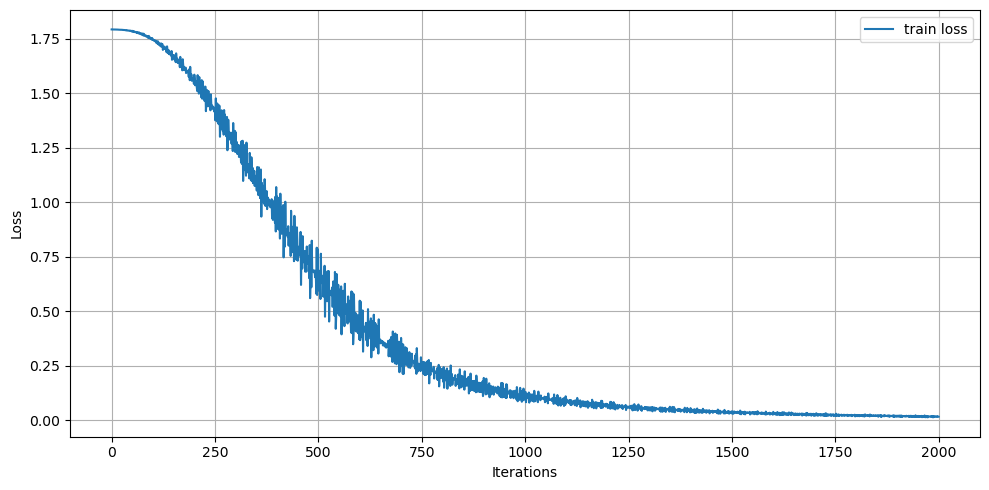

In [53]:
trainer.plot()